`KDD2024 Tutorial / A Hands-On Introduction to Time Series Classification and Regression`

# Convolutional Methods for Time Series Machine Learning

In this notebook, we will explore the convolutional methods for time series machine learning available in `aeon`. We will also demonstrate how `aeon` estimators are compatible with `scikit-learn` tuning functionality.

Convolutional methods are a class of algorithms that leverage randomly initialised convolutional kernels to extract features from time series data. These methods have been shown to be effective in time series classification tasks, and are very efficient to process.

This notebook mostly focuses on classification as this is the learning task these approaches were designed and published for, but they are easily adaptable to regression tasks as well. The regression versions and evaluations of them are unpublished, but are available in `aeon`.

## Table of Contents <a id='toc'></a>

* [Load example data](#load-data)
* [Rocket](#rocket)
* [MiniRocket](#minirocket)
    * [Parameter Tuning: **Num. Features**](#mini-tune)
* [MultiRocket](#multirocket)
* [Hydra](#hydra)
    * [Parameter Tuning: **Num. Groups (`g`), Num. Kernels Per Group (`k`)**](#hydra-tune)
* [MultiRocket+Hydra](#mrhydra)
* [Performance on the UCR univariate classification datasets](#evaluation)
* [References](#references)

In [2]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
from aeon.registry import all_estimators
all_estimators(
    "classifier", filter_tags={"algorithm_type": "convolution"}, as_dataframe=True
)

,name,estimator
0,Arsenal,<class 'aeon.classification.convolution_based....
1,HydraClassifier,<class 'aeon.classification.convolution_based....
2,MultiRocketHydraClassifier,<class 'aeon.classification.convolution_based....
3,RocketClassifier,<class 'aeon.classification.convolution_based....


In [3]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "convolution"}, as_dataframe=True
)

,name,estimator
0,HydraRegressor,<class 'aeon.regression.convolution_based._hyd...
1,MultiRocketHydraRegressor,<class 'aeon.regression.convolution_based._mr_...
2,RocketRegressor,<class 'aeon.regression.convolution_based._roc...


# Load Example Data <a id='load-data'></a>

In [4]:
from aeon.datasets import load_from_tsfile

X_train_c, y_train_c = load_from_tsfile("./data/KDD_MTSC_TRAIN.ts")
X_test_c, y_test_c = load_from_tsfile("./data/KDD_MTSC_TEST.ts")

print("Train shape:", X_train_c.shape)
print("Test shape:", X_test_c.shape)

Train shape: (40, 4, 100)
Test shape: (40, 4, 100)


In [5]:
X_train_r, y_train_r = load_from_tsfile("./data/KDD_MTSER_TRAIN.ts")
X_test_r, y_test_r = load_from_tsfile("./data/KDD_MTSER_TEST.ts")

print("Train shape:", X_train_r.shape)
print("Test shape:", X_test_r.shape)

Train shape: (72, 4, 100)
Test shape: (72, 4, 100)


## Rocket <a id='rocket'></a>
### `RocketClassifier()`

Rocket is the original convolutional method for time series classification [[1]](#references). It is available in `aeon`.

In [6]:
from aeon.classification.convolution_based import RocketClassifier

classifier = RocketClassifier(rocket_transform="rocket", random_state=0)
classifier.fit(X_train_c, y_train_c)
classifier.score(X_test_c, y_test_c)

0.45

## MiniRocket <a id='minirocket'></a>
### `RocketClassifier(rocket_transform = "minirocket")`

MiniRocket [[2]](#references) is a variant of Rocket that is almost deterministic and has been shown to be faster and more accurate than Rocket.

In [7]:
from aeon.classification.convolution_based import RocketClassifier

classifier = RocketClassifier(rocket_transform="minirocket", random_state=0)
classifier.fit(X_train_c, y_train_c)
classifier.score(X_test_c, y_test_c)

0.9

### `RocketRegressor(rocket_transform = "minirocket")`

In [8]:
from aeon.regression.convolution_based import RocketRegressor
from sklearn.metrics import r2_score

regressor = RocketRegressor(rocket_transform="minirocket", random_state=0)
regressor.fit(X_train_r, y_train_r)
preds = regressor.predict(X_test_r)
r2_score(y_test_r, preds)

0.38896015619917346

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

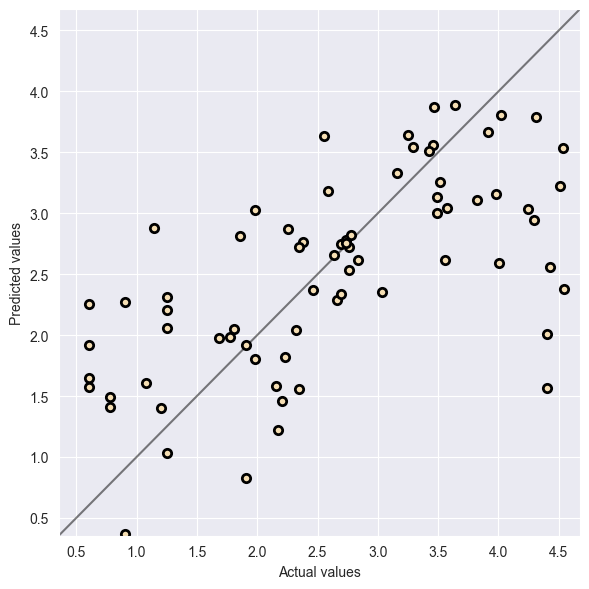

In [9]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, preds)

### Parameter Tuning: **Num. Features** <a id='mini-tune'></a>
#### `GridSearchCV()`

Grid search for the number of features (`num_kernels`) $\in \{100, 1{,}000, 10{,}000\}$ and `max_dilations_per_kernel` $\in \{16, 32, 64\}$ using `GridSearchCV()` from `scikit-learn`.

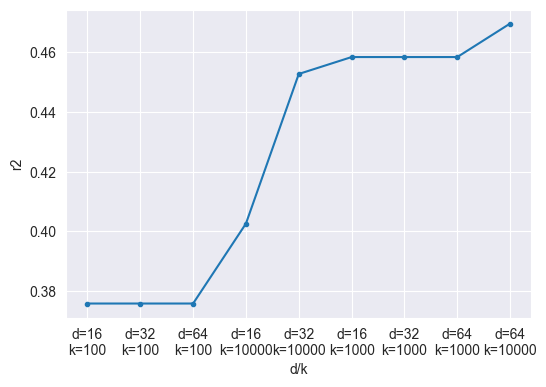

In [10]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# == fit =======================================================================
# ==============================================================================

param_grid = {
    "num_kernels" : [100, 1000, 10000],
    "max_dilations_per_kernel" : [16, 32, 64],
}

gs = GridSearchCV(
    RocketRegressor(rocket_transform="minirocket", random_state=0),
    param_grid,
)
gs.fit(X_train_r, y_train_r)

# ==============================================================================
# == plot results ==============================================================
# ==============================================================================

_scores = gs.cv_results_["mean_test_score"]
_params = np.array([f"d={_[0]}\nk={_[1]}" for _ in [tuple(_.values()) for _ in gs.cv_results_["params"]]])
_order = _scores.argsort()
_, a = plt.subplots(1, 1, figsize = (6, 4))
a.plot(_params[_order], _scores[_order], ".-")
a.set(xlabel = "d/k", ylabel = "r2")
plt.show()

score with best configuration.

In [11]:
gs.score(X_test_r, y_test_r)

0.3954466149391762

## MultiRocket <a id='multirocket'></a>
### `RocketClassifier(rocket_transform = "multirocket")`

MultiRocket [[3]](#references) is a further extension that uses multiple pooling operators and series transformations to improve classification performance.

In [12]:
from aeon.classification.convolution_based import RocketClassifier

classifier = RocketClassifier(rocket_transform="multirocket", random_state=0)
classifier.fit(X_train_c, y_train_c)
classifier.score(X_test_c, y_test_c)

0.9

## Hydra <a id='hydra'></a>
### `HydraClassifier()`

Hydra [[4]](#references) is a variant of Rocket that integrates features and
techniques from dictionary based approaches.
with `torch`.

In [13]:
from aeon.classification.convolution_based import HydraClassifier

classifier = HydraClassifier(random_state=0)
classifier.fit(X_train_c, y_train_c)
classifier.score(X_test_c, y_test_c)

0.9

### `HydraRegressor()`

In [14]:
from aeon.regression.convolution_based import HydraRegressor
from sklearn.metrics import r2_score

regressor = HydraRegressor(random_state=0)
regressor.fit(X_train_r, y_train_r)
preds = regressor.predict(X_test_r)
r2_score(y_test_r, preds)

0.4079838386357094

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

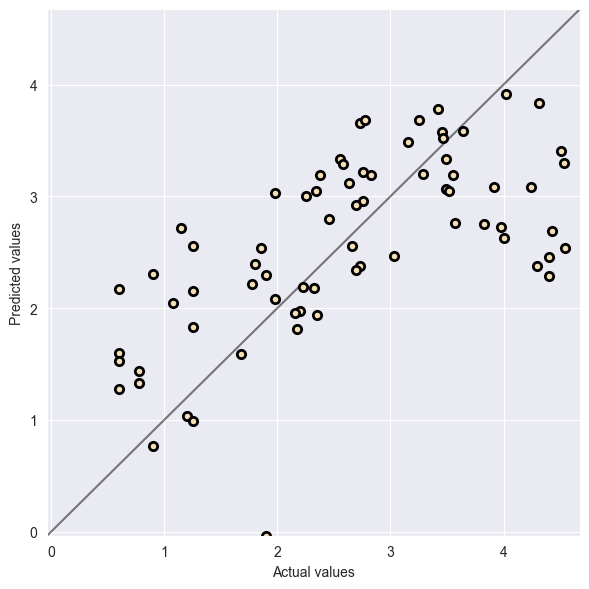

In [15]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, preds)

### Parameter Tuning: **Num. Groups (`g`), Num. Kernels Per Group (`k`)** <a id='hydra-tune'></a>
#### `RandomizedSearchCV()`

Random search over $k \in \{2, 4, 8, 16, 32\}$ and $g \in \{1, 2, 4, 8, 16, 32, 64, 128\}$ using `RandomizedSearchCV()` from `scikit-learn`.

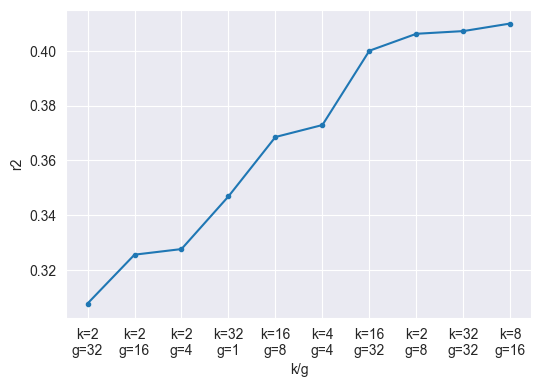

In [16]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# == fit =======================================================================
# ==============================================================================

param_grid = {
    "n_kernels" : [2, 4, 8, 16, 32],
    "n_groups"  : [1, 2, 4, 8, 16, 32, 64, 128],
}

rs = RandomizedSearchCV(
    HydraRegressor(random_state=0),
    param_grid,
    random_state=0,
)
rs.fit(X_train_r, y_train_r)

# ==============================================================================
# == plot results ==============================================================
# ==============================================================================

_scores = rs.cv_results_["mean_test_score"]
_params = np.array([f"k={_[0]}\ng={_[1]}" for _ in [tuple(_.values()) for _ in rs.cv_results_["params"]]])
_order = _scores.argsort()
_, a = plt.subplots(1, 1, figsize = (6, 4))
a.plot(_params[_order], _scores[_order], ".-")
a.set(xlabel = "k/g", ylabel = "r2")
plt.show()

score with best configuration.

In [17]:
rs.score(X_test_r, y_test_r)

0.42331978292703265

## MultiRocket+Hydra <a id='mrhydra'></a>
### `MultiRocketHydraClassifier()`

MultiRocket+Hydra [[4]](#references) combines the MultiRocket and Hydra approaches.

In [18]:
from aeon.classification.convolution_based import MultiRocketHydraClassifier

classifier = MultiRocketHydraClassifier(random_state=0)
classifier.fit(X_train_c, y_train_c)
classifier.score(X_test_c, y_test_c)

0.9

## Performance on the UCR univariate classification datasets <a id='evaluation'></a>

Below we show the performance of the convolution approaches shown on the UCR TSC archive datasets [[5]](#references) using results from a large scale comparison of TSC algorithms [[6]](#references). The results files are stored on [timeseriesclassification.com](timeseriesclassification.com).

In [19]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = ["Rocket", "MiniRocket", "MultiRocket", "Hydra", "MultiRocketHydra", "1NN-DTW"]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 6)

In [20]:
import numpy as np

np.mean(results, axis=0)

array([0.85581294, 0.85803176, 0.86567363, 0.85349016, 0.86802991,
       0.74206624])

(<Figure size 600x250 with 1 Axes>, <Axes: >)

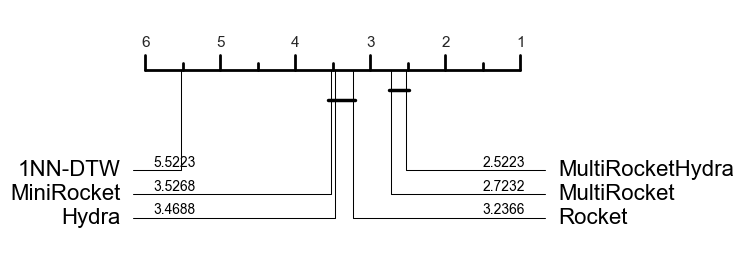

In [21]:
from aeon.visualisation import plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

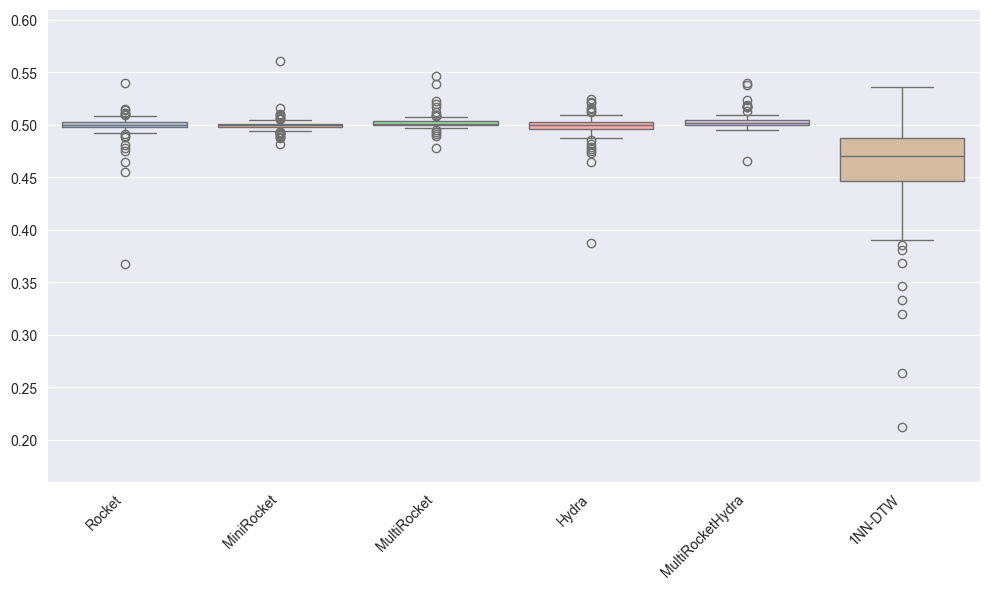

In [22]:
from aeon.visualisation import plot_boxplot_median

plot_boxplot_median(results, names, plot_type="boxplot")

## References <a id='references'></a>

[1] Dempster, A., Petitjean, F., & Webb, G. I. (2020). ROCKET: exceptionally fast and accurate time series classification using random convolutional kernels. Data Mining and Knowledge Discovery, 34(5), 1454-1495.

[2] Dempster, A., Schmidt, D. F., & Webb, G. I. (2021, August). Minirocket: A very fast (almost) deterministic transform for time series classification. In Proceedings of the 27th ACM SIGKDD conference on knowledge discovery & data mining (pp. 248-257).

[3] Tan, C. W., Dempster, A., Bergmeir, C., & Webb, G. I. (2022). MultiRocket: multiple pooling operators and transformations for fast and effective time series classification. Data Mining and Knowledge Discovery, 36(5), 1623-1646.

[4] Dempster, A., Schmidt, D. F., & Webb, G. I. (2023). Hydra: Competing convolutional kernels for fast and accurate time series classification. Data Mining and Knowledge Discovery, 37(5), 1779-1805.

[5] Dau, Hoang Anh, et al. "The UCR time series archive." IEEE/CAA Journal of Automatica Sinica 6.6 (2019): 1293-1305.

[6] Middlehurst, Matthew, Patrick Schäfer, and Anthony Bagnall. "Bake off redux: a review and experimental evaluation of recent time series classification algorithms." Data Mining and Knowledge Discovery (2024): 1-74.

[Return to Table of Contents](#toc)